## Mean-Variance Hedging (MVH)
- MVH formulation of hedging tries to solve a stepwise mean variance problem,
$$\min_{\text{strategies}}\left(\sum_{t=1}^{N-1}\mathbb{E}(-P\&L_t)+\frac{\lambda}{2}\text{Var}(P\&L_t)\right)$$
- The P\&L at each step is defined as:
- For $0\leq i n$,
$$P\&L_{i+1}=(C_{i+1}-C_{i})+H_i(S_{i+1}-S_i)-\kappa|S_{i+1}(H_{i+1}-H_i)|$$
- where, $C_i$ (negative if option is shorted) is the option price and $H_i$ is the hedging strategy (shares of stock to hold) between $i\Delta t$ and $(i+1)\Delta t$
- At $i=0$ there is cost $\kappa|S_0H_0|$ to set up the hedge
- At $i=N$ there is cost $\kappa|S_NH_N|$ to unwind the hedge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/RL&Hedging/')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from Utilities import commonFunctions as cF

In [ ]:
def Training_Loss_Kolm(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples):
    """
    Formulate the optimization objective based on Kolm-Rietter formulation
    Calculate the average loss for the batch
    S: Stock prices (BATCH_SIZE,TIME_STEP)
    C: Option prices (BATCH_SIZE,TIME_STEP)
    D: Option Deltas (BATCH_SIZE,TIME_STEP)
    PHI: Hedging strategy(BATCH_SIZE,TIME_STEP+1)
    PHI_dot: rebalancing rate(BATCH,TIME_STEP)
    LAM: Risk aversion parameter
    TIME: Time horizon T"""
    delta_t = TIME/time_step
    pnl_mat = cF.torch.zeros((n_samples,time_step+1))
    # initial transaction cost to put on the hedge
    pnl_mat[:,0] = -kappa*cF.torch.abs(cF.torch.mul(S[:,0],PHI[:,0]))
    for i in cF.torch.arange(1,time_step):
        pnl_mat[:,i] = -1*(C[:,i]-C[:,i-1])+PHI[:,i]*(S[:,i]-S[:,i-1])-kappa*S[:,i]*(cF.torch.abs(PHI_dot[:,i]*delta_t)+0.01*(PHI_dot[:,i]*delta_t)**2)
    #transaction cost at maturity to unwind the hedge
    pnl_mat[:,-1] = pnl_mat[:,-1]-kappa*S[:,-1]*(cF.torch.abs(PHI[:,-1])+0.01*PHI[:,-1]**2)
    loss_mat = -1*pnl_mat+LAM/2*pnl_mat**2 #loss_mat.shape =(n_samples,time_step)
    return cF.torch.mean(loss_mat), pnl_mat

In [ ]:
def TRAIN_graph(S_0,vol,mu,ir,K,PHI_INITIAL,LAM,kappa,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,LR_Utility = 0.001,saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0):

    """
    n_samples: path size of the Brownian Motion
    time_step: discretization step
    LR_Utility: initial learning rate
    saving: list, to indicate at which epoch should have the models be saved to the path_temp
         saving=0 means no saving
    LR_Adjust: a dictoinary in which the value is the absolute DECAY,
          and the key is the epoch corresponding to the updated learning rate
    OPT_Utility: "ADAM" or "SGD"
    """
    model_list_Utility = []
    i = 0
    while i <= time_step:
        model = cF.RL_Net(INPUT_DIM_Utility,OUTPUT_DIM,HIDDEN_DIM_Utility)
        model.apply(cF.weights_init_uniform_rule)
        model_list_Utility.append(model)
        i += 1
    if OPT_Utility=="SGD":
        optimizer_Utility = cF.torch.optim.SGD((par for model in model_list_Utility
                        for par in model.parameters()),
                                lr=LR_Utility)
    if OPT_Utility=="ADAM":
        optimizer_Utility = cF.torch.optim.Adam((par for model in model_list_Utility
                        for par in model.parameters()),
                        lr=LR_Utility, betas=(0.9, 0.99))

    loss_arr_Utility = []
    PHI_0=cF.torch.ones(n_samples)*PHI_INITIAL
    DUMMY_1 = cF.torch.ones(n_samples).reshape((n_samples, 1))
    for epoch in cF.tqdm(range(EPOCH)):
        ### tuning the learning rate
        if epoch in LR_Adjust.keys():
            DECAY = LR_Adjust[epoch]
            for g in optimizer_Utility.param_groups:
                g['lr'] = LR_Utility*DECAY

        ### W_t: (SAMPLE_SIZE,TIME_STEP+1)
        W=cF.torch.cumsum(cF.torch.normal(0, cF.np.sqrt(TIME*1/time_step), size=(n_samples, time_step)), dim=1) # simukate Wiener process
        W=cF.torch.cat((cF.torch.zeros((n_samples,1)),W),dim=1)

        ### Stock process batch(SAMPLE_SIZE,TIME_STEP+1)
        S = cF.calculate_stock_prices(S_0,mu,vol,W)

        ### Calculate option prices batch (SAMPLE_SIZE,TIME_STEP+1)
        C = cF.calculate_option_prices(S, K, ir, vol, TIME)
        ### Calculate option deltas
        D = cF.calculate_deltas(S, K, ir, vol, TIME)

        optimizer_Utility.zero_grad()
        PHI = cF.torch.zeros((n_samples, time_step + 1))

        PHI[:,0] = PHI_0.reshape((-1,))

        PHI_dot = cF.torch.zeros((n_samples, time_step ))

        for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(SAMPLE_SIZE,TIME_STEP)
            t_tensor=t/time_step*TIME*cF.torch.ones(n_samples).reshape(-1,1)
            x_Utility=cF.torch.cat((t_tensor,W[:,t].reshape(-1,1),C[:,t].reshape(-1,1),D[:,t].reshape(-1,1),PHI[:,t].reshape(-1,1)),dim=1)
            PHI_dot[:,t] = model_list_Utility[t](x_Utility).reshape(-1,)
            PHI[:,(t+1)] = PHI[:,t].reshape(-1)+PHI_dot[:,(t)].reshape(-1)*TIME/time_step
        loss_Utility, _ = Training_Loss_Kolm(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples)
        loss_arr_Utility.append(loss_Utility.data)
        loss_Utility.backward()   #compute gradient
        optimizer_Utility.step()  #update NN weights
        if cF.np.isinf(loss_Utility.data.cpu().numpy()) or cF.np.isnan(loss_Utility.data.cpu().numpy()):
            print("\nFAIL")
            break
        ### saving
        path_Q = './models/'
        if saving:
            if epoch%100==0:
                for i,model in enumerate(model_list_Utility):
                      cF.torch.save(model.state_dict(),path_Q+'Utility_para{}.pkl'.format(i))
                cF.torch.save(loss_arr_Utility,path_Q+"Utility_LOSS_arr.pt")
                cF.torch.save(optimizer_Utility.state_dict(),path_Q+"Utility_optimizer.pt")
                print("\n saving models after {} Epochs".format(epoch+1))
    result={
        'loss':loss_arr_Utility,
        'model_list':model_list_Utility
      }
    return(result)

In [ ]:
S_0 =100
K =100
vol = 0.20/cF.np.sqrt(252)
mu = 0.05/252
ir = mu
PHI_INITIAL = 0.0
LAM = 0.1
TIME = 30
EPOCH =50
n_samples = 5000
time_step = 30
LR_Utility = 0.001
INPUT_DIM_Utility = 5 #The dimension of the input is 5:(t,W_t,C_t,Delta_t,phi_t)
OUTPUT_DIM = 1
HIDDEN_DIM_Utility = [10,15,10]
kappa = 0.01

### Train Deep-MVH for increasing maturities

In [ ]:
time_list = [30, 60, 90, 120]
delta_pnl_dict = {}
deep_pnl_dict = {}
deep_model_dict = {}
for TIME in time_list:
  time_step = TIME
  print('training with maturity (days) ={}'.format(TIME))
  result = TRAIN_graph(S_0,vol,mu,ir,K,PHI_INITIAL,LAM,kappa,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,LR_Utility = 0.001,saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)
  deep_model_dict['model_maturity_{}'.format(TIME)] = result['model_list']
  model_list_Utility = result['model_list']
  ### calulate pnl on test set
  n_samples = 1000
    ### W_t: (SAMPLE_SIZE,TIME_STEP+1)
  W=cF.torch.cumsum(cF.torch.normal(0, cF.np.sqrt(TIME*1/time_step), size=(n_samples, time_step)), dim=1) # simukate Wiener process
  W=cF.torch.cat((cF.torch.zeros((n_samples,1)),W),dim=1)

  ### Stock process batch(SAMPLE_SIZE,TIME_STEP+1)
  S = cF.calculate_stock_prices(S_0,mu,vol,W)

  ### Calculate option prices batch (SAMPLE_SIZE,TIME_STEP+1)
  C = cF.calculate_option_prices(S, K, ir, vol, TIME)
  ### Calculate option deltas
  D = cF.calculate_deltas(S, K, ir, vol, TIME)
  PHI = cF.torch.zeros((n_samples, time_step + 1))
  PHI_0 = cF.torch.ones(n_samples)*PHI_INITIAL
  PHI[:,0] = PHI_0.reshape((-1,))

  PHI_dot = cF.torch.zeros((n_samples, time_step ))

  for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(SAMPLE_SIZE,TIME_STEP)
      t_tensor=t/time_step*TIME*cF.torch.ones(n_samples).reshape(-1,1)
      x_Utility=cF.torch.cat((t_tensor,W[:,t].reshape(-1,1),C[:,t].reshape(-1,1),D[:,t].reshape(-1,1),PHI[:,t].reshape(-1,1)),dim=1)
      PHI_dot[:,t] = model_list_Utility[t](x_Utility).reshape(-1,)
      PHI[:,(t+1)] = PHI[:,t].reshape(-1)+PHI_dot[:,(t)].reshape(-1)*TIME/time_step

  _,pnl_mat = Training_Loss_Kolm(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples)
  deep_pnl_dict['pnl_maturity_{}'.format(TIME)] = pnl_mat.detach().numpy()


training with maturity (days) =30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


training with maturity (days) =60


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


training with maturity (days) =90


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


training with maturity (days) =120


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


### Paste trained graphs and build 60d, 90 strategies using 30d

In [ ]:
deep_model_dict['model_maturity_pasted_60'] = deep_model_dict['model_maturity_30'] +deep_model_dict['model_maturity_30'][1:]
deep_model_dict['model_maturity_pasted_90'] = deep_model_dict['model_maturity_30'] +deep_model_dict['model_maturity_30'][1:]+deep_model_dict['model_maturity_30'][1:]
deep_model_dict['model_maturity_pasted_120']  = deep_model_dict['model_maturity_30'] +deep_model_dict['model_maturity_30'][1:]+deep_model_dict['model_maturity_30'][1:]+deep_model_dict['model_maturity_30'][1:]


In [ ]:
print(deep_model_dict.keys())

dict_keys(['model_maturity_30', 'model_maturity_60', 'model_maturity_90', 'model_maturity_120', 'model_maturity_pasted_60', 'model_maturity_pasted_90', 'model_maturity_pasted_120'])


### Out of sample performance for pasted 60d, 90d and 120d maturity

In [ ]:
for TIME in [60, 90, 120]:
  time_step = TIME
  n_samples = 1000
  model_list_Utility = deep_model_dict['model_maturity_pasted_{}'.format(TIME)]
    ### W_t: (SAMPLE_SIZE,TIME_STEP+1)
  W=cF.torch.cumsum(cF.torch.normal(0, cF.np.sqrt(TIME*1/time_step), size=(n_samples, time_step)), dim=1) # simukate Wiener process
  W=cF.torch.cat((cF.torch.zeros((n_samples,1)),W),dim=1)

  ### Stock process batch(SAMPLE_SIZE,TIME_STEP+1)
  S = cF.calculate_stock_prices(S_0,mu,vol,W)

  ### Calculate option prices batch (SAMPLE_SIZE,TIME_STEP+1)
  C = cF.calculate_option_prices(S, K, ir, vol, TIME)
  ### Calculate option deltas
  D = cF.calculate_deltas(S, K, ir, vol, TIME)
  PHI = cF.torch.zeros((n_samples, time_step + 1))

  PHI[:,0] = PHI_0.reshape((-1,))

  PHI_dot = cF.torch.zeros((n_samples, time_step ))

  for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(SAMPLE_SIZE,TIME_STEP)
      t_tensor=t/time_step*TIME*cF.torch.ones(n_samples).reshape(-1,1)
      x_Utility=cF.torch.cat((t_tensor,W[:,t].reshape(-1,1),C[:,t].reshape(-1,1),D[:,t].reshape(-1,1),PHI[:,t].reshape(-1,1)),dim=1)
      PHI_dot[:,t] = model_list_Utility[t](x_Utility).reshape(-1,)
      PHI[:,(t+1)] = PHI[:,t].reshape(-1)+PHI_dot[:,(t)].reshape(-1)*TIME/time_step

  _,pnl_mat = Training_Loss_Kolm(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples)
  deep_pnl_dict['pnl_maturity_pasted_{}'.format(TIME)] = pnl_mat.detach().numpy()


In [ ]:
deep_pnl_dict.keys()

dict_keys(['pnl_maturity_30', 'pnl_maturity_60', 'pnl_maturity_90', 'pnl_maturity_120', 'pnl_maturity_pasted_60', 'pnl_maturity_pasted_90', 'pnl_maturity_pasted_120'])

# Import RL Models

In [ ]:
from collections import namedtuple
import statistics
import time
import os
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.models import clone_model, load_model, Model
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.optimizers import adam_v2
Adam = adam_v2.Adam
from tensorflow.python.keras.initializers import Zeros, Ones, Constant, he_normal, truncated_normal
from tensorflow.python.keras import backend

from Utilities.black_scholes_helper import call_option
from Utilities.path_generator import geometric_brownian_generator, wiener_process_generator
tf.compat.v1.disable_eager_execution()

%load_ext autoreload
%autoreload 2

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/RL&Hedging/')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/RL&Hedging'

In [ ]:
from brains import *
from agents import *
from trainers import*
from environments import *

In [ ]:
MU = 0.05 / 252
IR = MU
VOL = 0.20 / np.sqrt(252)
S0 = 100
K = 100
NUM_SOLD_OPT = 1
KAPPA = 0.1
ALPHA = 0.01
GAMMA = 1.0
CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 1000
FREQ_UPDATE_TARGET = 5

In [ ]:
def load_and_run(NUM_STEPS, num_paths=3000, file_ddpg='/content/drive/MyDrive/Colab Notebooks/RL&Hedging/rl-bsmodel-with-costs-master/model_data/ddpg_no_costs', file_dqn='/content/drive/MyDrive/Colab Notebooks/RL&Hedging/rl-bsmodel-with-costs-master/model_data/dqn_no_costs.h5'):

    # Results of DDPG agent
    num_states = env.num_states
    act_rng = (0, NUM_SOLD_OPT)
    rp = None
    agentDPG = AgentDDPG(num_states, 1, act_rng, random_process=rp, actor_lr=1e-5, critic_lr=1e-4, tau=1e-3)
    agentDPG.load(file_ddpg)

    trainer = TrainerBS(env, agentDPG)
    p_hists = trainer.run(num_paths, NUM_STEPS)
    p_pl = np.sum(p_hists[:, :, -1], axis=1)

    # Results of DQN agent
    brainDQN = BrainDQN(num_states, NUM_SOLD_OPT+1)
    brainDQN.load(file_dqn)
    agentDQN = AgentActionValueBase(brainDQN)

    trainer = TrainerBS(env, agentDQN)
    q_hists = trainer.run(num_paths, NUM_STEPS)
    q_pl = np.sum(q_hists[:, :, -1], axis=1)

    # Results of Delta agent
    brainDelta = BrainDelta(num_states, NUM_SOLD_OPT+1, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)

    trainer = TrainerBS(env, agentDelta)
    d_hists = trainer.run(num_paths, NUM_STEPS)
    d_pl = np.sum(d_hists[:, :, -1], axis=1)

    return d_hists, p_hists, q_hists, d_pl, p_pl, q_pl

In [ ]:
env = EnvironmentBS(60, 60, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, alpha=ALPHA)
d_hists1, p_hists1, q_hists1, d_pl1, p_pl1, q_pl1 = load_and_run(60,NUM_EPISODES, '/content/drive/MyDrive/Colab Notebooks/RL&Hedging/rl-bsmodel-with-costs-master/model_data/ddpg_maturity60d')

env = EnvironmentBS(90, 90, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, alpha=ALPHA)
d_hists2, p_hists2, q_hists2, d_pl2, p_pl2, q_pl2 = load_and_run(90,NUM_EPISODES, '/content/drive/MyDrive/Colab Notebooks/RL&Hedging/rl-bsmodel-with-costs-master/model_data/ddpg_maturity90d')

env = EnvironmentBS(120, 120, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, alpha=ALPHA)
d_hists3, p_hists3, q_hists3, d_pl3, p_pl3, q_pl3 = load_and_run(120,NUM_EPISODES, '/content/drive/MyDrive/Colab Notebooks/RL&Hedging/rl-bsmodel-with-costs-master/model_data/ddpg_maturity120d')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


1e-05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1e-05


1e-05


In [ ]:
def plot_pl_hists(dh_pl, dh_pl_pasted,rl_pl,T, ax, hist=True):

    sns.distplot(-dh_pl, label="Deep-MVH", color='midnightblue', hist_kws={"alpha":0.3}, ax=ax, hist=hist)
    sns.distplot(-dh_pl_pasted, label="Deep-MVH-pasted", color='gold', hist_kws={"alpha":0.3}, ax=ax, hist=hist)
    sns.distplot(-rl_pl, label="RL-MVH", color='green', hist_kws={"alpha":0.3}, ax=ax, hist=hist)

    ax.axvline(-dh_pl.mean(), color='midnightblue', ls='--')
    ax.axvline(-dh_pl_pasted.mean(), color='gold', ls='--')
    ax.axvline(-rl_pl.mean(), color='green', ls='--')

    ax.set_xlim(-20, 100)
    ax.set_xlabel('Total Hedge Quality', fontsize=16)
    ax.set_ylabel('Probability Density')
    ax.set_title('Option Maturity (day) = {}'.format(T))
    ax.legend(frameon=True)

    print("Option Maturity = {}".format(T))
    print("Dep-MVH: Ave = {0:.2f}, Std = {1:.2f}".format(-dh_pl.mean(), dh_pl.std(ddof=1)))
    print("Deep-MVH-pasted: Ave = {0:.2f}, Std = {1:.2f}".format(-dh_pl_pasted.mean(), dh_pl_pasted.std(ddof=1)))
    print("RL-DDPG: Ave = {0:.2f}, Std = {1:.2f}".format(-rl_pl.mean(), rl_pl.std(ddof=1)))
    print("")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Option Maturity = 60
Dep-MVH: Ave = 11.44, Std = 6.17
Deep-MVH-pasted: Ave = 7.19, Std = 7.20
RL-DDPG: Ave = 1.19, Std = 5.37

Option Maturity = 90
Dep-MVH: Ave = 14.38, Std = 8.09
Deep-MVH-pasted: Ave = 11.28, Std = 12.34
RL-DDPG: Ave = 1.17, Std = 6.01



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Option Maturity = 120
Dep-MVH: Ave = 20.34, Std = 11.56
Deep-MVH-pasted: Ave = 16.93, Std = 19.30
RL-DDPG: Ave = 1.01, Std = 6.81



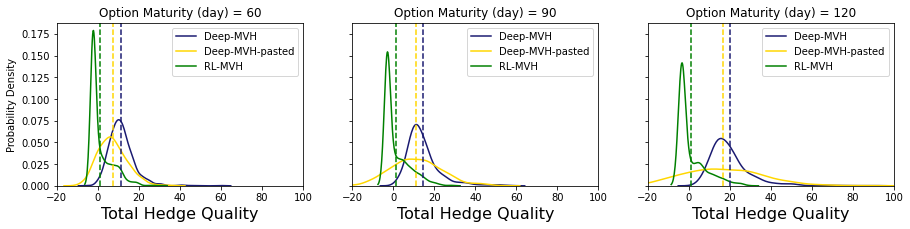

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[15,3])

plot_pl_hists(np.sum(deep_pnl_dict['pnl_maturity_60'],axis=1),np.sum(deep_pnl_dict['pnl_maturity_pasted_60'],axis=1),p_pl1,60, axes[0], False)
plot_pl_hists(np.sum(deep_pnl_dict['pnl_maturity_90'],axis=1),np.sum(deep_pnl_dict['pnl_maturity_pasted_90'],axis=1),p_pl2,90, axes[1], False)
plot_pl_hists(np.sum(deep_pnl_dict['pnl_maturity_120'],axis=1),np.sum(deep_pnl_dict['pnl_maturity_pasted_120'],axis=1),p_pl3,120, axes[2], False)